In [1]:
import pyterrier as pt
import pandas as pd
from pyterrier.measures import RR, nDCG, MAP

In [2]:
dataset = pt.get_dataset("irds:beir/fiqa")

In [7]:
# Install the nlpaug package
# %pip install nlpaug

import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

# from nlpaug.util import Action

In [22]:
text = 'The quick brown fox jumps over the lazy dog .'
aug = nac.RandomCharAug(action="substitute", aug_char_p=0.8)

augmented_texts = aug.augment(text)

print("Original:")
print(text)
print("Augmented Texts:")
print(augmented_texts)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Texts:
['The quick 9ry)B fox &Pv1s QEQ& the lazy dog.']


In [23]:
# Add noise to the documents
noisy_dataset = []
bool = False

aug = nac.RandomCharAug(aug_char_p=0.3, aug_word_p=0.3, action="substitute", aug_word_min=1, aug_word_max=500000)

for doc in dataset.get_corpus_iter():
    noisy_text = aug.augment(doc['text'])
    noisy_doc = {'docno': doc['docno'], 'text': noisy_text}
    noisy_dataset.append(noisy_doc)

    if not bool:
        print(doc['text'])
        print("Noisy:")
        print(noisy_text)
        bool = True

I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything.
Noisy:
["I ' m not saying I don ' t Jikm the iHCa of on - the - job training too, but you can ' t expect the cUmpaIs to do XhDt. 9Iainin8 wsr1e8s is not th+sr job - 4iey ' re bui_DNng software. Per$Cps _EucaAionkl NyDte9s in the U. S. (or theWL students) vhoulu wSrDy a little abdct 9Qrting marketable suiTls in exchange for vheur maybiWe invest7kst in education, rather t3a& getting out w8Rh PhoBsaqds in studeR& djby and then cTmOpai0ing that t!Ky ar&r ' t qualified to do Dnythz%g."]


beir/fiqa documents: 100%|██████████| 57638/57638 [01:40<00:00, 573.09it/s]


In [24]:
# Indexing noisy documents - takes too long
# from pathlib import Path

# indexer = pt.IterDictIndexer(
#     str(Path.cwd()),  # this will be ignored
#     type=pt.index.IndexingType.MEMORY,
# )
# index_ref = indexer.index(noisy_dataset, fields=["text"])

In [25]:
# To test the noisy documents
# bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
# testset = pt.get_dataset("irds:beir/fiqa/test")
# pt.Experiment(
#     [bm25],
#     testset.get_topics(),
#     testset.get_qrels(),
#     eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
# )

In [12]:
# Indexing documents
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
    fields=["text"]
)
index_ref = indexer.index(dataset.get_corpus_iter())

















































































































































































































































































































































































































































































































beir/fiqa documents: 100%|██████████| 57638/57638 [00:27<00:00, 2063.53it/s]


In [27]:
# Add noise to the queries
# Load the test dataset
testset = pt.get_dataset("irds:beir/fiqa/test")

# Retrieve test queries
test_queries = testset.get_topics()

# Add noise by deleting characters 10% of the time
aug = nac.RandomCharAug(action="delete", aug_char_p=0.1, spec_char="")

# Apply noise to queries
noisy_queries_list = []
for _, row in test_queries.iterrows():
    noisy_query = aug.augment(row['query'])

    if isinstance(noisy_query, list):
        noisy_query = " ".join(noisy_query)

    noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

noisy_queries_df = pd.DataFrame(noisy_queries_list)
noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

print("Original Query:", test_queries.iloc[0]['query'])
print("Noisy Query:", noisy_queries_df.iloc[0]['query'])

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

# Run the experiment
pt.Experiment(
    [bm25],
    noisy_queries_df,
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)

Original Query: where should i park my rainy day emergency fund
Noisy Query: where should i park my ainy day mergency fud
09:51:39.680 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,RR@10,nDCG@10,AP@100
0,TerrierRetr(BM25),0.145615,0.120467,0.099014


In [28]:
# Define a Sequential Augmentation Pipeline (Substitution + Insert)
# Load the test dataset
testset = pt.get_dataset("irds:beir/fiqa/test")

# Retrieve test queries
test_queries = testset.get_topics()

aug = naf.Sequential([
    nac.RandomCharAug(action="substitute", aug_char_p=0.2, spec_char=""),  # Substitute 20% of characters
    nac.RandomCharAug(action="insert", aug_char_p=0.2, spec_char="")       # Insert characters in 20% of positions
])

# Apply noise to queries
noisy_queries_list = []
for _, row in test_queries.iterrows():
    noisy_query = aug.augment(row['query'])

    if isinstance(noisy_query, list):
        noisy_query = " ".join(noisy_query)

    noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

noisy_queries_df = pd.DataFrame(noisy_queries_list)

noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

print("Original Query:", test_queries.iloc[0]['query'])
print("Noisy Query:", noisy_queries_df.iloc[0]['query'])

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

# Run the experiment
pt.Experiment(
    [bm25],
    noisy_queries_df,
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)


Original Query: where should i park my rainy day emergency fund
Noisy Query: yhere should i Opark my raSny day eFer8gxnc9y pfund
09:51:54.767 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,RR@10,nDCG@10,AP@100
0,TerrierRetr(BM25),0.076055,0.066641,0.054936


In [13]:
testset = pt.get_dataset("irds:beir/fiqa/test")
test_queries = testset.get_topics()

# Define noise levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Define different noise type proportions
noise_combinations = [
    {"sub": 1.0, "ins": 0.0, "del": 0.0},  # Only substitution
    {"sub": 0.0, "ins": 1.0, "del": 0.0},  # Only insertion
    {"sub": 0.0, "ins": 0.0, "del": 1.0},  # Only deletion
    {"sub": 0.5, "ins": 0.5, "del": 0.0},  # Substitution + Insertion
    {"sub": 0.5, "ins": 0.0, "del": 0.5},  # Substitution + Deletion
    {"sub": 0.0, "ins": 0.5, "del": 0.5},  # Insertion + Deletion
    {"sub": 0.33, "ins": 0.33, "del": 0.33},  # Equal mix
]

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
results = []

for noise_level in noise_levels:
    for noise_config in noise_combinations:
        # Set noise probabilities
        sub_prob = noise_level * noise_config["sub"]
        ins_prob = noise_level * noise_config["ins"]
        del_prob = noise_level * noise_config["del"]

        # print(f"Noise Level: {noise_level}")
        # print(f"Substitution Probability: {sub_prob}")
        # print(f"Insertion Probability: {ins_prob}")
        # print(f"Deletion Probability: {del_prob}")

        aug = naf.Sequential([
            nac.RandomCharAug(action="substitute", aug_char_p=0.25, aug_word_p=sub_prob, spec_char="", aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000),
            nac.RandomCharAug(action="insert", aug_char_p=0.25, aug_word_p=ins_prob, spec_char="", aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000),
            nac.RandomCharAug(action="delete", aug_char_p=0.25, aug_word_p=del_prob, aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000)
        ])

        # Apply noise to queries
        noisy_queries_list = []
        for _, row in test_queries.iterrows():
            noisy_query = aug.augment(row['query'])
            if isinstance(noisy_query, list):
                noisy_query = " ".join(noisy_query)
            noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

        noisy_queries_df = pd.DataFrame(noisy_queries_list)
        noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

        # print("Original query:", test_queries.iloc[0]['query'])
        # print("Noisy query:", noisy_queries_df.iloc[0]['query'])

        # Run retrieval experiment
        eval_result = pt.Experiment(
            [bm25],
            noisy_queries_df,
            testset.get_qrels(),
            eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
        )

        # Store results
        eval_result["noise_level"] = noise_level
        eval_result["sub_prob"] = sub_prob
        eval_result["ins_prob"] = ins_prob
        eval_result["del_prob"] = del_prob
        results.append(eval_result)

# Combine results
final_results = pd.concat(results, ignore_index=True)
print(final_results)


20:16:10.291 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


beir/fiqa documents:   0%|          | 0/57638 [04:37<?, ?it/s]


                 name     RR@10   nDCG@10    AP@100  noise_level  sub_prob  \
0   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
1   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
2   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
3   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
4   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
5   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
6   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
7   TerrierRetr(BM25)  0.242874  0.200563  0.160619          0.1     0.100   
8   TerrierRetr(BM25)  0.232410  0.191982  0.157652          0.1     0.000   
9   TerrierRetr(BM25)  0.241576  0.203086  0.162698          0.1     0.000   
10  TerrierRetr(BM25)  0.243741  0.198886  0.162648          0.1     0.050   
11  TerrierRetr(BM25)  0.223746  0.185496  0.150792          0.1

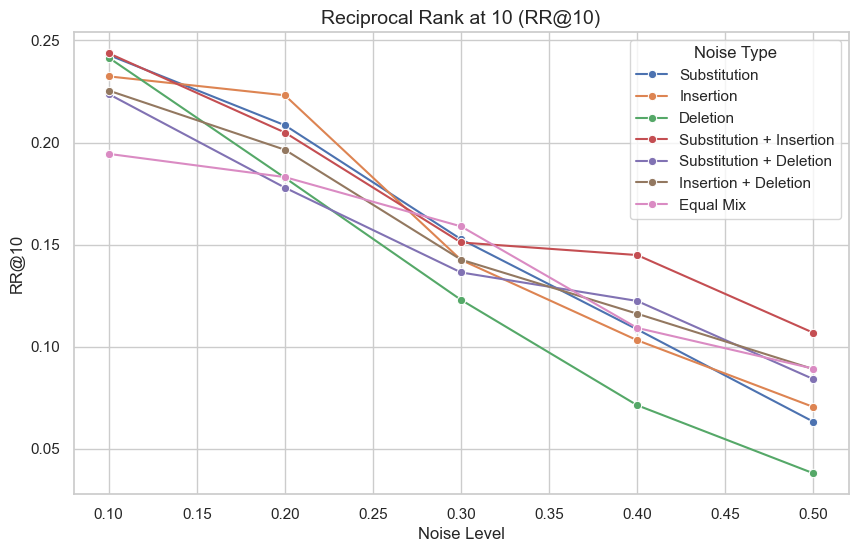

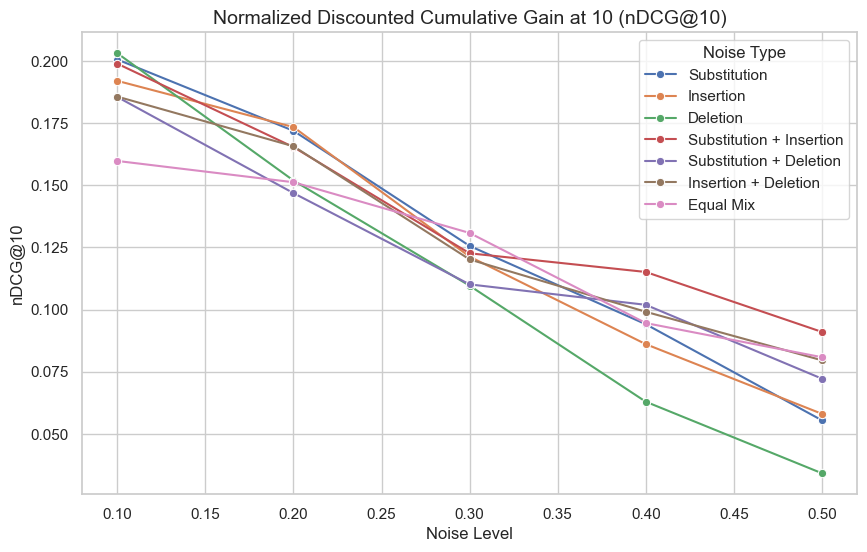

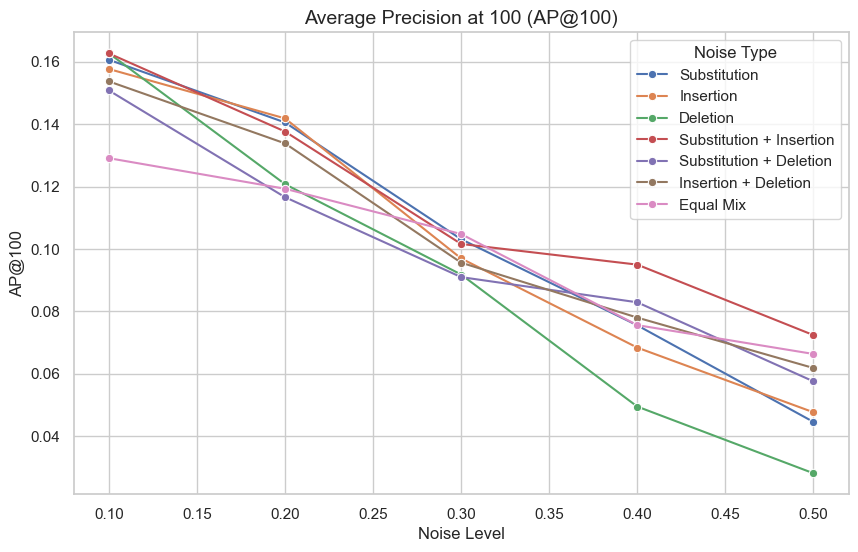

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_noise_label(row):
    if row["sub_prob"] > 0 and row["ins_prob"] == 0 and row["del_prob"] == 0:
        return "Substitution"
    elif row["sub_prob"] == 0 and row["ins_prob"] > 0 and row["del_prob"] == 0:
        return "Insertion"
    elif row["sub_prob"] == 0 and row["ins_prob"] == 0 and row["del_prob"] > 0:
        return "Deletion"
    elif row["sub_prob"] > 0 and row["ins_prob"] > 0 and row["del_prob"] == 0:
        return "Substitution + Insertion"
    elif row["sub_prob"] > 0 and row["ins_prob"] == 0 and row["del_prob"] > 0:
        return "Substitution + Deletion"
    elif row["sub_prob"] == 0 and row["ins_prob"] > 0 and row["del_prob"] > 0:
        return "Insertion + Deletion"
    elif row["sub_prob"] == row["ins_prob"] == row["del_prob"] and row["sub_prob"] != 0 and row["ins_prob"] != 0 and row["del_prob"] != 0:
        return "Equal Mix"

final_results["Noise Type"] = final_results.apply(get_noise_label, axis=1)

sns.set(style="whitegrid")

def plot_metric(metric, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=final_results,
        x="noise_level",
        y=metric,
        hue="Noise Type",
        marker="o"
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Noise Level", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(title="Noise Type")
    plt.show()

plot_metric("RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric("nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric("AP@100", "Average Precision at 100 (AP@100)")